<a href="https://colab.research.google.com/github/soy-min/climate-prognosis/blob/main/ClimatePrognosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM

Globale Parameter

In [310]:
START_YEAR_OBSERVATION='1963-01-01'
OBSERVATION_LOCATION_NAME='DEFAULT'

CSV laden

In [311]:
# Laden der CSV-Datei
#df = pd.read_csv('SW000002361.csv')
df = pd.read_csv('USC00122825.csv')
OBSERVATION_LOCATION_NAME=df.iloc[1]['NAME']
print(df.head())

       STATION     DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USC00122825  1893-01   40.2538   -85.1484      294.1   
1  USC00122825  1893-02   40.2538   -85.1484      294.1   
2  USC00122825  1893-04   40.2538   -85.1484      294.1   
3  USC00122825  1893-05   40.2538   -85.1484      294.1   
4  USC00122825  1893-06   40.2538   -85.1484      294.1   

                    NAME  CDSD  CDSD_ATTRIBUTES  CLDD CLDD_ATTRIBUTES  ...  \
0  FARMLAND 5 NNW, IN US   0.0              6.0   0.0              ,6  ...   
1  FARMLAND 5 NNW, IN US   0.0              6.0   0.0             2,6  ...   
2  FARMLAND 5 NNW, IN US   NaN              NaN   5.3              ,6  ...   
3  FARMLAND 5 NNW, IN US   NaN              NaN   9.7              ,6  ...   
4  FARMLAND 5 NNW, IN US   NaN              NaN   NaN             NaN  ...   

    SNOW SNOW_ATTRIBUTES   TAVG TAVG_ATTRIBUTES   TMAX TMAX_ATTRIBUTES   TMIN  \
0    NaN             NaN  -8.37              ,6  -3.54            ,,,6 -13.20   
1    NaN      

Reduzieren auf relevante Informationen

In [312]:
# Auswahl der relevanten Spalten (z.B. Datum, Temperatur)
df = df[['DATE', 'TAVG']]
# Umbenennen der Spalten
df = df.rename(columns={'DATE': 'date', 'TAVG': 'temp'})
# Festlegen des Indexes als Datum
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# reduzieren auf > START_YEAR_OBSERVATION
df=df.loc[START_YEAR_OBSERVATION:]
# NANs interpolieren
df=df.interpolate()
# einblick in die Daten
df

#TODO:
#- Sicherstellen, dass Daten vollständig verfügbar sind (keine NANs am Anfang)

,temp
date,
1963-01-01,-8.44
1963-02-01,-7.36
1963-03-01,4.08
1963-04-01,9.93
1963-05-01,13.69
...,...
2022-11-01,5.68
2022-12-01,-1.25
2023-01-01,1.82


Visualisieren der Daten

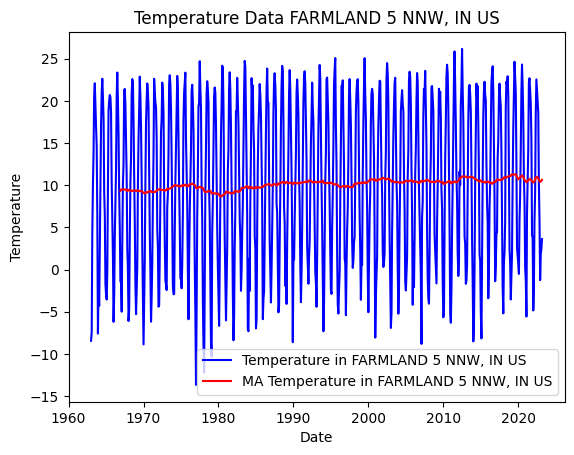

In [313]:
# Plotten der Ergebnisse
plt.plot(df.index, df['temp'], color='blue', label='Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df.rolling(window=48).mean()['temp'], color='red', label='MA Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Temperature Data '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Trainings und Testdaten separieren

In [314]:
# Teilen der Daten in Trainings- und Testdaten
train, test = train_test_split(df, test_size=0.2, shuffle=False)
# Ergebnis einsehen
test

,temp
date,
2011-02-01,-2.21
2011-03-01,4.47
2011-04-01,10.07
2011-05-01,16.54
2011-06-01,22.25
...,...
2022-11-01,5.68
2022-12-01,-1.25
2023-01-01,1.82


Normierung auf Werte 0..1

In [315]:
# Skalieren der Daten
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
# Ergebnis einsehen
test_scaled

array([[0.29581828],
       [0.46824987],
       [0.6128033 ],
       [0.77981415],
       [0.92720702],
       [1.02013423],
       [0.91997935],
       [0.79917398],
       [0.64481156],
       [0.56530718],
       [0.40397522],
       [0.33324729],
       [0.37274135],
       [0.65229737],
       [0.61151265],
       [0.85363965],
       [0.9145586 ],
       [1.02787816],
       [0.90242643],
       [0.80640165],
       [0.62958183],
       [0.45302013],
       [0.43211151],
       [0.30924109],
       [0.31879195],
       [0.36706247],
       [0.60015488],
       [0.8084667 ],
       [0.90862158],
       [0.91765617],
       [0.88926174],
       [0.83634486],
       [0.66572019],
       [0.44656686],
       [0.3159525 ],
       [0.13319566],
       [0.18482189],
       [0.35389778],
       [0.61564275],
       [0.78084667],
       [0.92178627],
       [0.87222509],
       [0.9145586 ],
       [0.79710893],
       [0.65229737],
       [0.3988126 ],
       [0.37971089],
       [0.222

In [ ]:


# Vorbereiten der Trainingsdaten
look_back = 60 # Anzahl der vorherigen Monate, die zur Vorhersage verwendet werden
X_train = []
y_train = []
for i in range(look_back, len(train_scaled)):
    X_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Umformen der Daten in das erforderliche 3D-Array-Format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Definieren und Trainieren des LSTM-Modells
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)




Epoch 1/100
17/17 [==============================] - 12s 510ms/step - loss: 0.1974
Epoch 2/100
17/17 [==============================] - 1s 85ms/step - loss: 0.0736
Epoch 3/100
17/17 [==============================] - 2s 121ms/step - loss: 0.0728
Epoch 4/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0676
Epoch 5/100
17/17 [==============================] - 3s 155ms/step - loss: 0.0670
Epoch 6/100
17/17 [==============================] - 2s 128ms/step - loss: 0.0660
Epoch 7/100
17/17 [==============================] - 2s 103ms/step - loss: 0.0643
Epoch 8/100
17/17 [==============================] - 2s 115ms/step - loss: 0.0603
Epoch 9/100
17/17 [==============================] - 2s 116ms/step - loss: 0.0562
Epoch 10/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0495
Epoch 11/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0327
Epoch 12/100
17/17 [==============================] - 3s 193ms/step - loss: 0.0100
Epoch 13/100
17/

Modell Validieren

In [ ]:
# Vorbereiten der Testdaten
inputs = df[len(df) - len(test) - look_back:].values
inputs = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Vorhersage der Temperaturen
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Plotten der Ergebnisse
plt.plot(test.index, test['temp'], color='blue', label='Actual Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(test.index, predicted, color='red', label='Predicted Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Testing Temperature Forecast '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Prognose auf Zukunft anwenden

In [ ]:



predicted=None
df_future=df[-look_back:]
prediction_period=60 #months
results = np.zeros(shape=(prediction_period, 1))
last_known_dateindex=df_future.iloc[[-1]].index

for i in range(0,prediction_period):
  F_test = []
  inputs=scaler.transform(df_future[-look_back:].values)
  F_test.append(inputs)
  F_test= np.array(F_test)
  F_test = np.reshape(F_test, (F_test.shape[0], F_test.shape[1], 1))
  # Vorhersage der Temperaturen n=1
  predicted = model.predict(F_test)
  predicted = scaler.inverse_transform(predicted)
  predicted
  results[i]=predicted

  # add predicted element to df_future
  next_date = last_known_dateindex + pd.DateOffset(months=i+1)
  df_future=pd.concat([df_future,pd.DataFrame({'temp':predicted[0]}, index=next_date)])
  print("hier:"+str(next_date[0]))

results

In [ ]:


# Plotten der Ergebnisse
plt.plot(df_future[:look_back].index, df_future[:look_back], color='blue', label='Actual Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df_future[look_back:].index, df_future[look_back:], color='red', label='Predicted Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Testing Temperature Forecast '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

test